# Creating and saving and xarray datacube in .zarr format
- Convert images into a datacube, after pre-processing them in SNAP.
- Contains NDVI, EVI, NDWI from the Sentinel-2 satellite
- It can be used to be displayed in xcube server

In [2]:
import rioxarray
import glob
import os
from datetime import datetime
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

In [3]:
# SNAP-processed Sentinel-2 imagery
directory='/media/Cheetah_2/Data/S2_Indices_New/'
# List of files
dir_folders=[]
for root, dirs, files in os.walk(directory, topdown=False):
   for name in dirs:
      dir_folders.append(os.path.join(root, name))

# Manipulate filenames: remove vector_data subfolders from the list of directories
folders=[dir_folders[x].split('/vector_data')[0] for x in range(len(dir_folders))]
folders=list(set(folders))

# Extract image acquisition dates
date_str=[folders[x].split('_T30VVH_all.data')[0].split('_')[-1].split('T')[0] for x in range(len(folders))]

# sort them by time
datetime_objects = [datetime.strptime(x, '%Y%m%d') for x in date_str]
datetime_objects = sorted(datetime_objects)

# Transform to string as 20230515
sorted_dates_str=[datetime_objects[t].strftime('%Y%m%d') for t in range(len(datetime_objects))]

# Transform to string as 15May2023
sorted_dates_str_other=[datetime_objects[t].strftime('%d%b%Y') for t in range(len(datetime_objects))]
sorted_dates_str_other[0:3]


['03Jan2020', '08Jan2020', '18Jan2020']

(1, 2557, 2803)


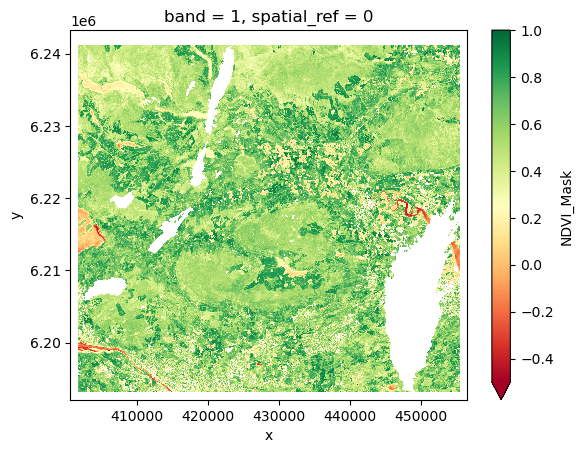

In [5]:
# Geometry as a JSON: around flanders

geometries = [
    {
        'type': 'Polygon',
        'coordinates': [[
[
              -4.258859662359328,
              56.17901598761185
            ],
            [
              -4.258859662359328,
              56.131234423962724
            ],
            [
              -4.155124159979692,
              56.131234423962724
            ],
            [
              -4.155124159979692,
              56.17901598761185
            ],
            [
              -4.258859662359328,
              56.17901598761185
            ]
        ]]
    }
]

# read one image with rioxarray to obtain img size and geocoordinates
img = folders[16]+'/NDVI_Mask.img'
raster = rioxarray.open_rasterio(img)
print(raster.shape)
raster.plot(cmap='RdYlGn',vmin=-0.5,vmax=1)

### Reproject imagery to EPSG:4326 and crop to keep area of interest only (peatland site)

(1, 178, 386)


/home/crs2/anaconda3/envs/skimage_env/lib/python3.11/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


/home/crs2/anaconda3/envs/skimage_env/lib/python3.11/site-packages/matplotlib/colors.py:718: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


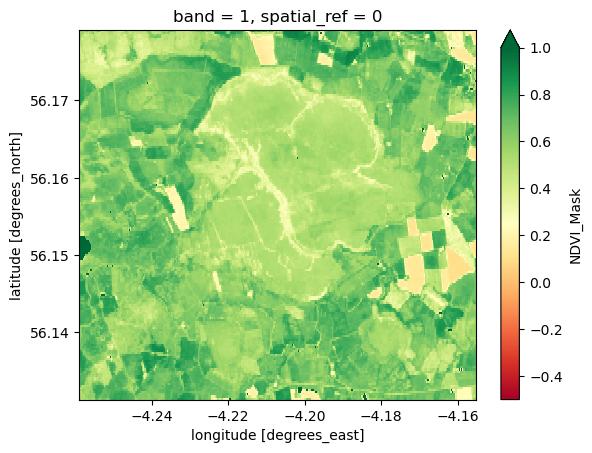

In [11]:
raster_reproj = raster.rio.reproject("EPSG:4326").rio.clip(geometries, from_disk=True)
print(raster_reproj.shape)
raster_reproj.plot(cmap='RdYlGn',vmin=-0.5,vmax=1)

In [12]:
# test projection
raster_reproj.rio.crs

CRS.from_epsg(4326)

In [ ]:
# numpy arrays to prepare data for a datacube
ls_imgs=np.arange(0,len(folders))
NDVI  =np.zeros((ls_imgs.shape[0],raster_reproj.shape[1],raster_reproj.shape[2]))
NDWI  =np.zeros((ls_imgs.shape[0],raster_reproj.shape[1],raster_reproj.shape[2]))
NDVIre=np.zeros((ls_imgs.shape[0],raster_reproj.shape[1],raster_reproj.shape[2]))
EVI   =np.zeros((ls_imgs.shape[0],raster_reproj.shape[1],raster_reproj.shape[2]))

for i,j in enumerate(ls_imgs):
    img = folders[i]+'/NDVI_Mask.img'
    raster = rioxarray.open_rasterio(img)
    clipped = raster.rio.reproject("EPSG:4326").rio.clip(geometries, from_disk=True)
    
    NDVI[i,:,:]=clipped[0]
    print(np.median(clipped[0]))

    # img = folders[i]+'/NDWI_Mask.img'
    # clipped = rioxarray.open_rasterio(img)
    # NDWI[i,:,:]=clipped[0]

    # img = folders[i]+'/NDVIre_Mask.img'
    # clipped = rioxarray.open_rasterio(img)
    # NDVIre[i,:,:]=clipped[0]

    # img = folders[i]+'/EVI2.img'
    # clipped = rioxarray.open_rasterio(img)
    # EVI[i,:,:]=clipped[0]


In [ ]:
# plot an example
# y=3
# fig,((ax),(ax1),(ax2))=plt.subplots(nrows=1,ncols=3,figsize=(18,6))
# ax.imshow(NDVI[y,:,:],cmap='RdYlGn',vmin=-0.5,vmax=1)
# ax1.imshow(NDVI[y+10,:,:],cmap='RdYlGn',vmin=-0.5,vmax=1)
# ax2.imshow(NDVI[y+20,:,:],cmap='RdYlGn',vmin=-0.5,vmax=1)

In [21]:
# get geocoordinates to incorporate them in the datacube
lat = raster_reproj.y.values
lon = raster_reproj.x.values
lat.shape

(178,)

In [22]:
# Create xarray dataset
ds = xr.Dataset({
    'NDVI': xr.DataArray(
        data = NDVI,
        # dims = ['lat','lon','time'],
        # coords = {'lat': lat, 'lon': lon,'time':dates_strptime[0:n]},
        dims = ['time','lat','lon'],
        coords = {'time':datetime_objects,'lat': lat, 'lon': lon},
        attrs = {'long_name': NDVI}
        ),

    # 'NDWI': xr.DataArray(
    #     data = NDWI,
    #     # dims = ['lat','lon','time'],
    #     # coords = {'lat': lat, 'lon': lon,'time':dates_strptime[0:n]},
    #     dims = ['time','lat','lon'],
    #     coords = {'time':datetime_objects,'lat': lat, 'lon': lon},
    #     attrs = {'long_name': 'NDWI'}
    #     ),

    # 'NDVIre': xr.DataArray(
    #     data = NDVIre,
    #     # dims = ['lat','lon','time'],
    #     # coords = {'lat': lat, 'lon': lon,'time':dates_strptime[0:n]},
    #     dims = ['time','lat','lon'],
    #     coords = {'time':datetime_objects,'lat': lat, 'lon': lon},
    #     attrs = {'long_name': 'NDVIre'}
    #     ),

    # 'EVI': xr.DataArray(
    #     data = EVI,
    #     # dims = ['lat','lon','time'],
    #     # coords = {'lat': lat, 'lon': lon,'time':dates_strptime[0:n]},
    #     dims = ['time','lat','lon'],
    #     coords = {'time':datetime_objects,'lat': lat, 'lon': lon},
    #     attrs = {'long_name': 'EVI'}
    #     )
    },
    attrs = {'Description': 'NDVI time series'}
    )

ds = ds.sortby('time')
ds

<xarray.Dataset>
Dimensions:  (time: 102, lat: 178, lon: 386)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-03 2020-01-08 ... 2022-09-14
  * lat      (lat) float64 56.18 56.18 56.18 56.18 ... 56.13 56.13 56.13 56.13
  * lon      (lon) float64 -4.259 -4.258 -4.258 -4.258 ... -4.156 -4.156 -4.155
Data variables:
    NDVI     (time, lat, lon) float64 0.6043 0.6644 ... 3.403e+38 3.403e+38
Attributes:
    Description:  NDVI time series

### plot imagery for different dates from the datacube

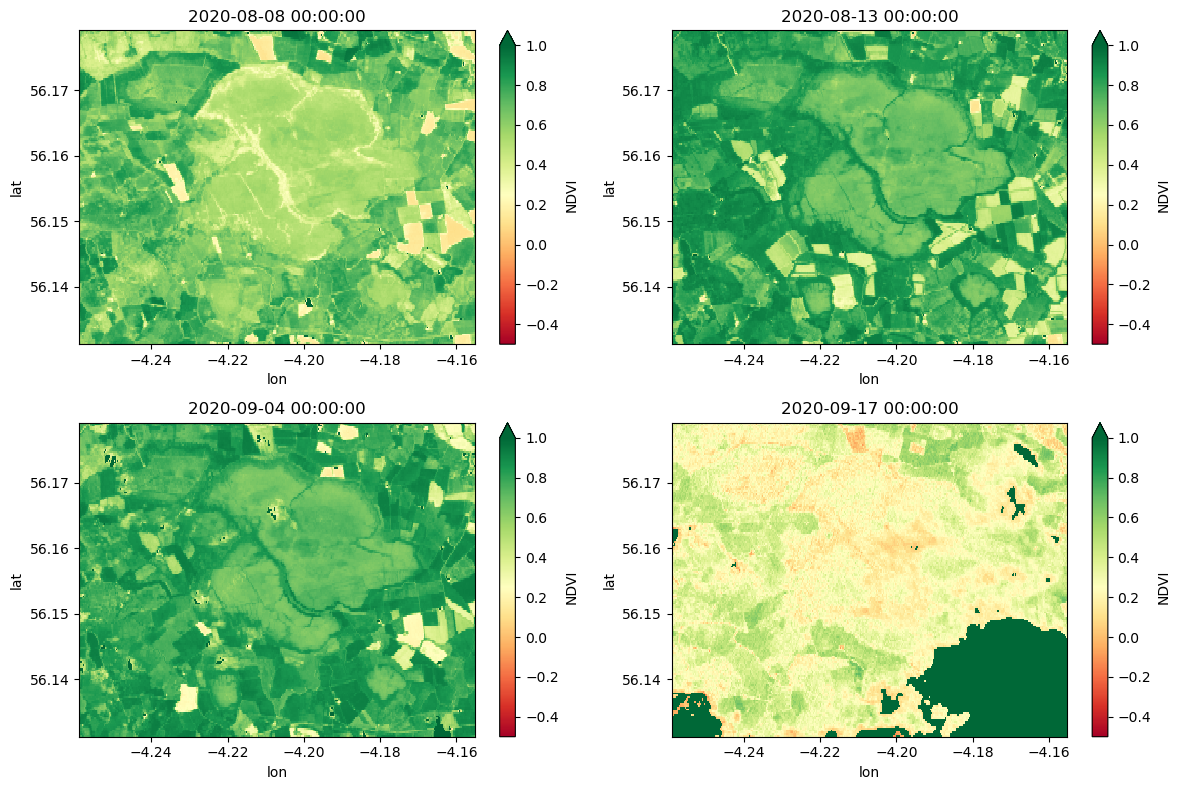

In [28]:

NDVI0 = ds.NDVI.isel(time=0)
NDVI40 = ds.NDVI.isel(time=15)
NDVI60 = ds.NDVI.isel(time=20)
NDVI80 = ds.NDVI.isel(time=25)

dates=[23,24,25,26]
counter=-1
f, axes = plt.subplots(2, 2, figsize=(12, 8))

for i in range(2):
    for j in range(2):
        counter=counter+1
        NDVI = ds.NDVI.isel(time=dates[counter])
        # The first plot (in kelvins) chooses "viridis" and uses the data's min/max
        NDVI.plot(ax=axes[i][j], cmap='RdYlGn',vmin=-0.5,vmax=1,cbar_kwargs={"label": "NDVI"})
        axes[i][j].set_title(pd.to_datetime(ds.time[dates[counter]].values))

plt.tight_layout()

#### save dataset as .zarr

In [30]:
# save dataset as .zarr
print('saving ...') 
dataset_out='/media/Scratch/Cristian/Tests/InSAR/NDVI_flanders'
#from pathlib import Path
#Path(dataset_out).mkdir(parents=True, exist_ok=True) # create directory if it doesn't exist
ds.to_zarr(dataset_out+'.zarr')

saving ...


#### plot time series of specific lat,lon locations

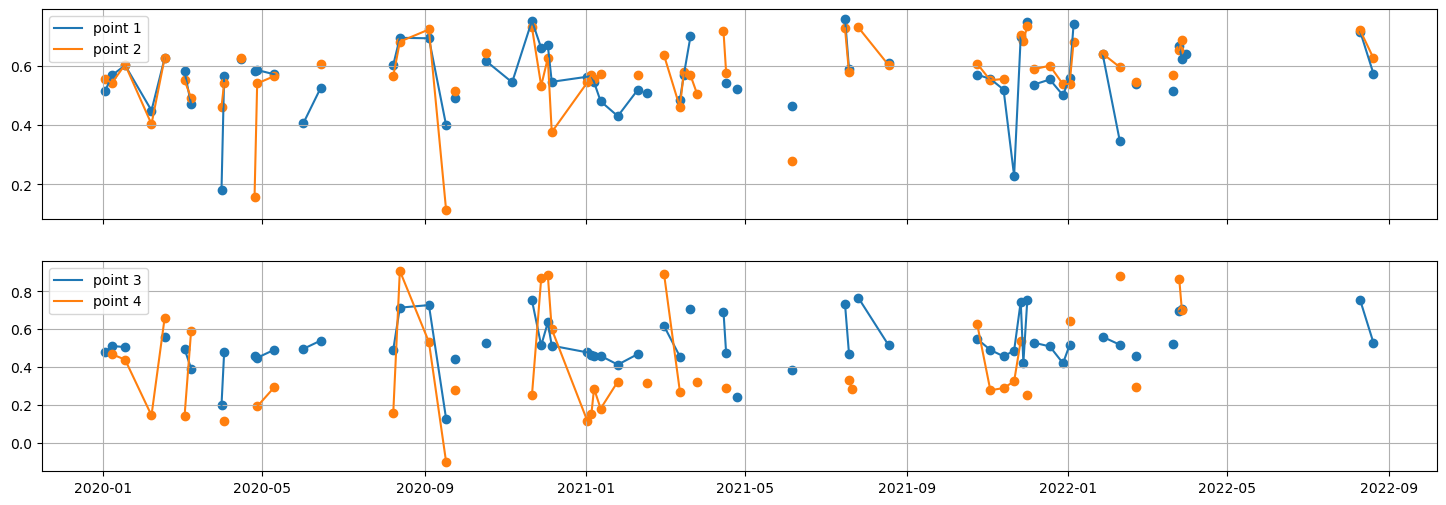

In [38]:
lat=56.1568
lon=-4.186824180917884
sample_point = ds.NDVI.sel(lat=lat, lon=lon, method='nearest')
df=pd.DataFrame(index=ds.time)
df['NDVI']=sample_point
df.loc[df.NDVI>10,'NDVI']=np.nan

lat=56.16416
lon=-4.19456
sample_point1 = ds.NDVI.sel(lat=lat, lon=lon, method='nearest')
df1=pd.DataFrame(index=ds.time)
df1['NDVI']=sample_point1
df1.loc[df1.NDVI>10,'NDVI']=np.nan

lat=56.160848
lon=-4.192273
sample_point2 = ds.NDVI.sel(lat=lat, lon=lon, method='nearest')
df2=pd.DataFrame(index=ds.time)
df2['NDVI']=sample_point2
df2.loc[df2.NDVI>10,'NDVI']=np.nan

# crop beside where we go in to flanders
lat = 56.175663
lon =-4.208766
sample_point3 = ds.NDVI.sel(lat=lat, lon=lon, method='nearest')
df3=pd.DataFrame(index=ds.time)
df3['NDVI']=sample_point3
df3.loc[df3.NDVI>10,'NDVI']=np.nan

fig,((ax),(ax1))=plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(18,6))
ax.plot(df.index,df.NDVI.values,label='point 1')
ax.scatter(df.index,df.NDVI.values)
ax.plot(df1.index,df1.NDVI.values,label='point 2')
ax.scatter(df1.index,df1.NDVI.values)
ax1.plot(df2.index,df2.NDVI.values,label='point 3')
ax1.scatter(df2.index,df2.NDVI.values)
ax1.plot(df3.index,df3.NDVI.values,label='point 4')
ax1.scatter(df3.index,df3.NDVI.values)
#sample_point.plot()
ax.legend()
ax1.legend()
ax.grid(True)
ax1.grid(True)